# Deep Learning Applications in Communications

By Jakob Hoydis, Stephan ten Brink, Sebastian Cammerer, and Sebastian Dörner.
Contact jakob.hoydis@nokia-bell-labs.com

This code is provided as supplementary material to the lecture course Deep Learning Applications in Communications.
It is licensed under the GPLv2 license. If you in any way use this code for research that results in publications, please cite it appropriately. 

## Basic end-to-end learned autoencoder communications model over an AWGN channel

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### This class defines the autoencoder model

In [2]:
class autoencoder(object):
    def __init__(self, seed=None, gpu_mem_frac=0.1, rtn=True, add_sequence=0):
        
        self.add_sequence = add_sequence
        self.rtn = rtn
        self.nb_messages = 256 #16 256
        self.nb_complex_symbols = 4 #2 #4
        self.bit_per_symbol = np.log2(self.nb_messages) / self.nb_complex_symbols
                       
        self.seed = seed if (seed is not None) else int(time.time())
            
        #Setup Graph and session        
        self.create_graph()
        self.create_session(gpu_mem_frac)
        return
    
    def create_graph(self):
        self.graph = tf.Graph()
        with self.graph.as_default():
    
            tf.set_random_seed(self.seed)

            ## Computational graph
            # Encoder
            s = tf.placeholder(tf.int64, [None])
            
            if self.add_sequence:
                s_seq = tf.expand_dims(s,axis=1)
                sequence_before = tf.random_uniform(shape=[tf.shape(s)[0],self.add_sequence],maxval=self.nb_messages,dtype=tf.int64)
                sequence_after = tf.random_uniform(shape=[tf.shape(s)[0],self.add_sequence],maxval=self.nb_messages,dtype=tf.int64)
                s_seq = tf.concat([sequence_before,s_seq,sequence_after],axis=1)
                s_seq = tf.reshape(s_seq, shape=[-1])
            else:
                s_seq = s
            
            x = self.encoder(s_seq)
            
            if self.add_sequence:
                x = tf.reshape(x, shape=[-1,2*self.add_sequence*self.nb_complex_symbols+self.nb_complex_symbols])
            
            # Channel
            ebnodb = tf.placeholder(tf.float32, shape=())
            y = self.channel(x, ebnodb)
            
            # Decoder
            s_hat = self.decoder(y)
    
            ## Loss functions
            cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=s_hat, labels=s))
            correct_predictions = tf.equal(tf.argmax(s_hat, axis=1), s)
            bler = 1-tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    
            ## Training operations
            lr = tf.placeholder(tf.float32, shape=())
            step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)
            
            ## Variables to be accessed after graph creation
            self.vars = {
                'bler': bler,
                's' : s,
                'x' : x,
                'y' : y,
                's_hat' : s_hat,
                'ebnodb' : ebnodb,
                'step' : step,
                'lr' : lr,
                'init': tf.global_variables_initializer()
            }
            
        return
    
    def create_session(self, gpu_mem_frac):
        sess_config = tf.ConfigProto()
        sess_config.gpu_options.per_process_gpu_memory_fraction = gpu_mem_frac
        self.sess = tf.Session(graph=self.graph, config=sess_config)
        self.sess.run(self.vars['init'])
        return
    
    def encoder(self, x):
        y = tf.one_hot(x, depth=self.nb_messages)
        y = tf.layers.dense(y, units=128, activation=tf.nn.relu)
        y = tf.layers.dense(y, units=128, activation=tf.nn.relu)
        y = tf.layers.dense(y, units=2*self.nb_complex_symbols, activation=None)
        y = tf.reshape(y, shape=[-1, self.nb_complex_symbols, 2])
        y = tf.complex(real=y[:,:,0], imag=y[:,:,1])
        y = self.encoder_output_normalization(y) 
        return y
    
    def channel(self, x, ebnodb):
        ### DO NOT CHANGE ###
        random_phase_offset = tf.random_uniform(shape=[tf.shape(x)[0],1], minval=0, maxval=2*np.pi)
        x = x * tf.exp(tf.complex(real=tf.zeros(shape=[tf.shape(x)[0],1]), imag=random_phase_offset))
        sigma = self.ebnodb2sigma(ebnodb)
        real_noise = tf.random_normal(shape=[tf.shape(x)[0],tf.shape(x)[1],2], mean=0.0, stddev=sigma)
        y = x + tf.complex(real=real_noise[:,:,0], imag=real_noise[:,:,1])
        return y
    
    def decoder(self, x):
        if self.rtn:
            x = self.phase_correction(x)
        y = tf.stack([tf.real(x), tf.imag(x)], axis=2)
        y = tf.reshape(y, shape=[-1, 2*(2*self.nb_complex_symbols*self.add_sequence+self.nb_complex_symbols)])
        y = tf.layers.dense(y, units=128, activation=tf.nn.relu)
        y = tf.layers.dense(y, units=128, activation=tf.nn.relu)
        y = tf.layers.dense(y, units=self.nb_messages, activation=None)
        return y
    
    def phase_correction(self,x):
        ### >>> Adding assisting radio transformer network here <<< ###
        original_signal = x
        z = tf.stack([tf.real(x), tf.imag(x)], axis=2)
        z = tf.reshape(z, shape=[-1, 2*(2*self.nb_complex_symbols*self.add_sequence+self.nb_complex_symbols)])
        z = tf.layers.dense(z,units=64, activation=tf.nn.relu)
        z = tf.layers.dense(z,units=64, activation=tf.nn.relu)
        z = tf.layers.dense(z,units= 2, activation=None)
        z = tf.reshape(z, shape=[-1,1,2])
        
        complex_offset = tf.complex(real=z[:,:,0],imag=z[:,:,1])
        #Normalization
        normalized_complex_offset = complex_offset/tf.cast(tf.abs(complex_offset), dtype=tf.complex64)
        y = tf.multiply(original_signal,normalized_complex_offset)
        
        #alpha  = tf.atan2(z[:,:,1],z[:,:,0])  
        #phase_offset_correction = tf.multiply(alpha,-1)
        #y = x * tf.exp(tf.complex(real=tf.zeros(shape=[tf.shape(x)[0],1]), imag=phase_offset_correction))
        return y
      
    def encoder_output_normalization(self, x):
        avg_message_power = tf.reduce_mean(tf.square(tf.abs(x)), axis=1, keepdims=True)
        y = x / tf.cast(tf.sqrt(avg_message_power), dtype=tf.complex64)
        return y
        
    def ebnodb2sigma(self, ebnodb):
        ebno = 10**(ebnodb/10)
        sigma = 1 / tf.sqrt(2 * self.bit_per_symbol * ebno)
        return sigma
    
    def gen_feed_dict(self, batch_size, ebnodb, lr=1e-3):
        return {
            self.vars['s']: np.random.randint(self.nb_messages, size=(batch_size)),
            self.vars['ebnodb']: ebnodb,
            self.vars['lr']: lr
        }      
    
    def receive(self, s, ebnodb):
        return self.sess.run(self.vars['y'], feed_dict={self.vars['s']: s, self.vars['ebnodb']: ebnodb})
    
    def transmit(self, s):
        return self.sess.run(self.vars['x'], feed_dict={self.vars['s']: s})
 
    def test_step(self, batch_size, ebnodb):
        return self.sess.run(self.vars['bler'], feed_dict=self.gen_feed_dict(batch_size, ebnodb))

    def test(self, test_parameters, plot=False):
        bler = np.zeros([len(test_parameters['ebnodb'])])
        for i in range(len(test_parameters['ebnodb'])):
            for j in range(test_parameters['num_avg']):
                bler[i] += self.test_step(test_parameters['size'], test_parameters['ebnodb'][i])
        bler = bler/test_parameters['num_avg']
        if (plot):
            self.plot_bler_vs_ebnodb(test_parameters['ebnodb'], bler)
        return bler
    
    def train_step(self, batch_size, ebnodb, lr):
        return self.sess.run(self.vars['step'], feed_dict=self.gen_feed_dict(batch_size, ebnodb, lr))
    
    def train(self, training_params):        
        pl = training_params['learning']
        pv = training_params['validation']
        for p in pl:
            
            print('\nBatch Size: ' + str(p[0]) + ', Learning Rate: ' + str(p[2]) + ', EbNodB: ' + str(p[3]))
            for i in range(p[1]):        
                self.train_step(p[0], p[3], p[2])
                if (i%pv['iterations'] == 0 and i>0):           
                    print('\tBLER ' + str(self.test_step(pv['size'], pv['ebnodb'])))
    
    def plot_encoder_constellations(self):
        s_all = np.arange(0,self.nb_messages)
        x = self.transmit(s_all)
        x = np.stack([np.real(x), np.imag(x)], axis=2)
        image = plt.figure(figsize=(6,6))
        max_value = np.max(np.abs(x))
        plt.xlim(-max_value-0.1,max_value+0.1)
        plt.ylim(-max_value-0.1,max_value+0.1)
        color = cm.rainbow(np.linspace(0,1,self.nb_messages))
        [plt.scatter(x[i,:,0],x[i,:,1],c=color[i]) for i in range(self.nb_messages)];
    
    def plot_bler_vs_ebnodb(self, ebnodb, bler):
        image = plt.figure(figsize=(8,8))
        plt.plot(ebnodb, bler, '-o')
        plt.yscale('log')
        plt.xlabel('EbNo (dB)', fontsize=16)
        plt.ylabel('Block-error rate', fontsize=16)

### Here we create an autoencoder model

In [3]:
ae_rtn = autoencoder(seed=1, rtn=True, add_sequence=3)
ae_baseline = autoencoder(seed=1, rtn=False, add_sequence=3)

### This defines the training parameters an runs the training process of our model

In [4]:
#Training parameters
train_ebnodb = 8
iterations = 5000
training_params = {
    'learning' : [ #batch_size, iterations, learning_rate, training_ebnodb
                [50,    iterations, 0.001,  train_ebnodb],
                [100,   iterations, 0.001,  train_ebnodb],
                [500,   iterations, 0.001,  train_ebnodb], 
                [1000,  iterations, 0.001,  train_ebnodb], 
                [5000,  iterations, 0.001,  train_ebnodb], 
                [10000, iterations, 0.001,  train_ebnodb],
                [10000, iterations, 0.0001, train_ebnodb],
               ],
    'validation' : {
        'size' : 100000,
        'iterations' : int(iterations/10),
        'ebnodb' : 8
    }    
}

In [5]:
%%time
ae_rtn.train(training_params)


Batch Size: 50, Learning Rate: 0.001, EbNodB: 8
	BLER 0.2683
	BLER 0.082589984
	BLER 0.08091998
	BLER 0.06645
	BLER 0.04228002
	BLER 0.057470024
	BLER 0.05053997
	BLER 0.04544002
	BLER 0.04786998

Batch Size: 100, Learning Rate: 0.001, EbNodB: 8
	BLER 0.020110011
	BLER 0.023100019
	BLER 0.026149988
	BLER 0.023379982
	BLER 0.027909994
	BLER 0.028789997
	BLER 0.025449991
	BLER 0.027670026
	BLER 0.026269972

Batch Size: 500, Learning Rate: 0.001, EbNodB: 8
	BLER 0.009010017
	BLER 0.009739995
	BLER 0.010609984
	BLER 0.011399984
	BLER 0.011120021
	BLER 0.011650026
	BLER 0.012030005
	BLER 0.012049973
	BLER 0.011550009

Batch Size: 1000, Learning Rate: 0.001, EbNodB: 8
	BLER 0.008440018
	BLER 0.009440005
	BLER 0.00849998
	BLER 0.008080006
	BLER 0.008469999
	BLER 0.008409977
	BLER 0.008899987
	BLER 0.008369982
	BLER 0.0079699755

Batch Size: 5000, Learning Rate: 0.001, EbNodB: 8
	BLER 0.005379975
	BLER 0.005469978
	BLER 0.0054399967
	BLER 0.005919993
	BLER 0.005400002
	BLER 0.005789995
	BLER 

In [6]:
%%time
ae_baseline.train(training_params)


Batch Size: 50, Learning Rate: 0.001, EbNodB: 8
	BLER 0.92445
	BLER 0.58207
	BLER 0.28314
	BLER 0.17209
	BLER 0.13406003
	BLER 0.09584999
	BLER 0.08831
	BLER 0.08239001
	BLER 0.07334

Batch Size: 100, Learning Rate: 0.001, EbNodB: 8
	BLER 0.043009996
	BLER 0.04154998
	BLER 0.044589996
	BLER 0.042209983
	BLER 0.045210004
	BLER 0.03922999
	BLER 0.04583001
	BLER 0.03899002
	BLER 0.039960027

Batch Size: 500, Learning Rate: 0.001, EbNodB: 8
	BLER 0.017719984
	BLER 0.017530024
	BLER 0.020240009
	BLER 0.02004999
	BLER 0.02098
	BLER 0.019460022
	BLER 0.020430028
	BLER 0.019959986
	BLER 0.020120025

Batch Size: 1000, Learning Rate: 0.001, EbNodB: 8
	BLER 0.016009986
	BLER 0.01624
	BLER 0.015770018
	BLER 0.01602
	BLER 0.01542002
	BLER 0.015089989
	BLER 0.016149998
	BLER 0.014599979
	BLER 0.014540017

Batch Size: 5000, Learning Rate: 0.001, EbNodB: 8
	BLER 0.010370016
	BLER 0.010339975
	BLER 0.010320008
	BLER 0.010309994
	BLER 0.010150015
	BLER 0.010309994
	BLER 0.009410024
	BLER 0.009079993
	B

### After training, we can evaluate the BLER performace of our autoencoder compared to conventional QPSK

Here a message/"block", as computed in the block error rate (BLER), refers to a sequence of 4 complex channel uses (symbols) which each carry 2 Bit/Symbol of information. This forms a message alphabet of $2^{4 \cdot 2} = 256$ different messages $s$ which the autoencoder can encode and decode. We compare such a message with a block of 4 consecutive QPSK symbols (which also carry 2 Bit/Symbol of information). 

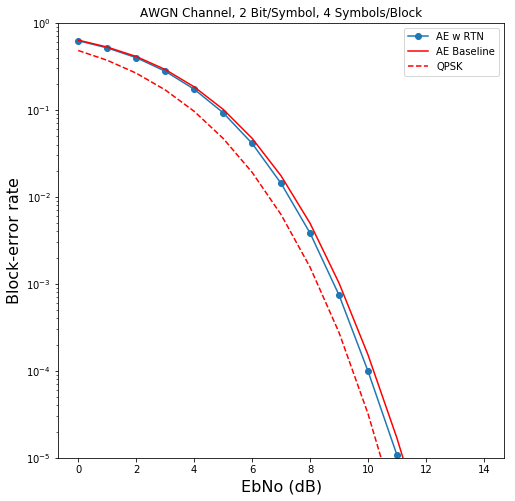

In [7]:
# Autoencoder
test_parameters = {
    'size' : 100000,
    'num_avg' : 100,
    'ebnodb' : np.arange(0,15,1)
}
bler_ae_rtn = ae_rtn.test(test_parameters, plot=True)
bler_ae_baseline = ae_baseline.test(test_parameters, plot=False)
plt.plot(test_parameters['ebnodb'], bler_ae_baseline, color='red');

#QPSK
BLER_QPSK = [4.818329E-01, 3.720104E-01, 2.645386E-01, 1.698987E-01, 9.636992E-02, 4.703772E-02, 1.914436E-02, 6.244719E-03, 1.551032E-03, 2.745986E-04, 3.194809E-05, 2.384186E-06, 0.000000E+00, 0.000000E+00, 0.000000E+00 ]
#autoencoder_baseline = [0.7649990081787109, 0.6824200093746186, 0.5795569896697998, 0.4612720012664795, 0.3363680005073547, 0.21999799609184265, 0.12593799829483032, 0.06071500182151794, 0.02378000020980835, 0.0075379908084869385, 0.0017919957637786866, 0.00033400654792785643, 3.600716590881348e-05, 4.00543212890625e-06, 1.0013580322265625e-06]

plt.plot(test_parameters['ebnodb'], BLER_QPSK,'--', color='red');
#plt.plot(test_parameters['ebnodb'], autoencoder_baseline,'--', color='green');

plt.title('AWGN Channel, 2 Bit/Symbol, 4 Symbols/Block')
plt.legend(['AE w RTN', 'AE Baseline', 'QPSK']);
plt.ylim([1e-5,1]);

### Finally we can plot the symbol constellations our encoder part came up with for each message

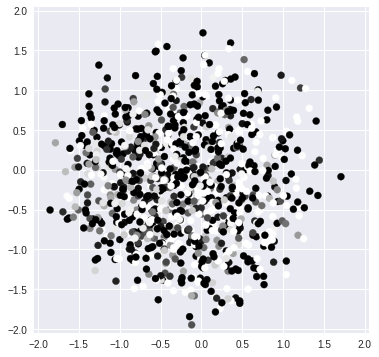

In [50]:
ae_model.plot_encoder_constellations()